In [1]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

from datetime import datetime, timedelta
import numpy as np
import glob
import os
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
import pandas as pd
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pmdarima as pm
from pmdarima.arima import ADFTest
from dateutil.relativedelta import relativedelta, MO
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# Adjusting the Data (STELLA)
Before we are able to train any ML models, the data must be cleaned and adjusted due to its stochastic and irregular data.

In [ ]:
# Define the folder path where .txt files are stored
folder_path = "Stela_measur"  # Change this to your actual folder path

# Use glob to get all .txt files in the folder
txt_files = glob.glob(os.path.join(folder_path, "*.txt"))

# Create an empty list to store DataFrames
df_list = []

# The column names of the DataFrame to be created
column_names = ["Time", "Tpv", "Tamb", "g", "Vwd"]

# Loop through each .txt file and read it
for file in txt_files:
    df = pd.read_csv(file, delimiter="\t", header=None, names=column_names)  # Read with tab separator, change delimiter if separator is different
    df["Date"] = os.path.basename(file)  # Add a new column with the file name
    df = df.drop([0])
    df_list.append(df)  # Append to the list

# Concatenate all DataFrames into one big DataFrame
df_Stella_All = pd.concat(df_list, ignore_index=True)

# Display the first few rows
print(df_Stella_All.head())

       Time  Tpv Tamb    g  Vwd          Date
0  00:02:13  NaN  NaN  NaN  NaN  20240101.txt
1  00:05:59    7    9    2    3  20240101.txt
2  00:10:13    7    9    0    2  20240101.txt
3  01:17:40    6    9    0    1  20240101.txt
4  01:22:13    6    9    0    3  20240101.txt


In [ ]:
# move the 'Date' column to the first position in the DataFrame
date_col = df_Stella_All.pop('Date')
df_Stella_All.insert(0, 'Date', date_col)

# Drop NaN values / Change the 'NaN' string to actual NaN values first
df_Stella_All = df_Stella_All.replace('NaN', np.nan)
df_Stella_All = df_Stella_All.dropna()

# Create a copy of the DataFrame
df_Stella_copy = df_Stella_All

# Change the following values to the indices in which the date's property ends
year = 4 # Index in which year ends
month = 6 # Index in which month ends
day = 8 # Index in which day ends
df_Stella_copy['Date'] = df_Stella_copy['Date'].str[:year] + ':' + df_Stella_copy['Date'].str[year:month] + ':' + df_Stella_copy['Date'].str[month:day] + ':'
df_Stella_copy['d&t'] = df_Stella_copy['Date'] + df_Stella_copy['Time']

# move the 'd&t' column to the first position in the DataFrame
date_col = df_Stella_copy.pop('d&t')
df_Stella_copy.insert(0, 'd&t', date_col)

df_Stella_copy.pop('Date')
df_Stella_copy.pop('Time')
df_Stella_copy['d&t'] = pd.to_datetime(df_Stella_copy['d&t'].str.replace(':', ''), format='%Y%m%d%H%M%S', infer_datetime_format=True)
df_Stella_copy = df_Stella_copy.set_index(['d&t'])
df_Stella_copy

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_21060\759862304.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Stella_copy['d&t'] = pd.to_datetime(df_Stella_copy['d&t'].str.replace(':', ''), format='%Y%m%d%H%M%S', infer_datetime_format=True)


,Tpv,Tamb,g,Vwd
d&t,,,,
2024-01-01 00:05:59,7,9,2,3
2024-01-01 00:10:13,7,9,0,2
2024-01-01 01:17:40,6,9,0,1
2024-01-01 01:22:13,6,9,0,3
2024-01-01 02:33:08,6,9,1,4
...,...,...,...,...
2025-02-10 23:59:16,3,3,0,0
2025-02-10 23:59:27,3,3,1,0
2025-02-10 23:59:37,2,3,0,0


With the data now cleaned from the NULL values, and with its 'Date' object specified, we can try handling the irregular data.

In [5]:
# Using to_numeric() method with downcasting
df_Stella_copy['Tpv'] = pd.to_numeric(df_Stella_copy['Tpv'], downcast='integer', errors='coerce')
df_Stella_copy['Tamb'] = pd.to_numeric(df_Stella_copy['Tamb'], downcast='integer', errors='coerce')
df_Stella_copy['g'] = pd.to_numeric(df_Stella_copy['g'], downcast='integer', errors='coerce')
df_Stella_copy['Vwd'] = pd.to_numeric(df_Stella_copy['Vwd'], downcast='integer', errors='coerce')

array([<Axes: xlabel='d&t'>, <Axes: xlabel='d&t'>, <Axes: xlabel='d&t'>,
       <Axes: xlabel='d&t'>], dtype=object)

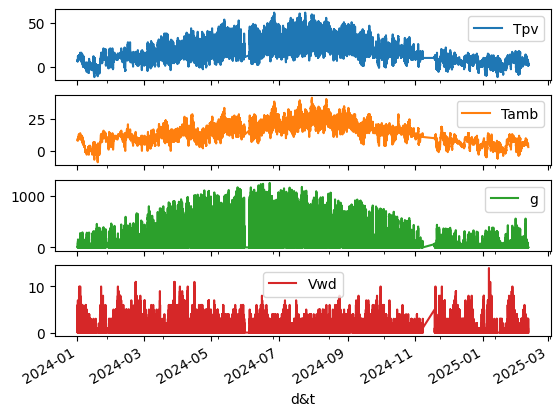

In [6]:
df_Stella_copy.plot(subplots=True)

In [ ]:
# Resample to 1 hour intervals, taking the mean of available values
df_resampled = df_Stella_copy.resample('1H').mean()

# Interpolate missing values linearly
df_resampled = df_resampled.interpolate(method='linear')

# Display the first few rows
print(df_resampled.head())

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_21060\3485764691.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_Stella_copy.resample('1H').mean()


                      Tpv  Tamb    g  Vwd
d&t                                      
2024-01-01 00:00:00  7.00   9.0  1.0  2.5
2024-01-01 01:00:00  6.00   9.0  0.0  2.0
2024-01-01 02:00:00  6.50   9.0  0.5  2.0
2024-01-01 03:00:00  6.50   8.0  2.0  3.0
2024-01-01 04:00:00  6.75   8.0  2.0  4.5


array([<Axes: xlabel='d&t'>, <Axes: xlabel='d&t'>, <Axes: xlabel='d&t'>,
       <Axes: xlabel='d&t'>], dtype=object)

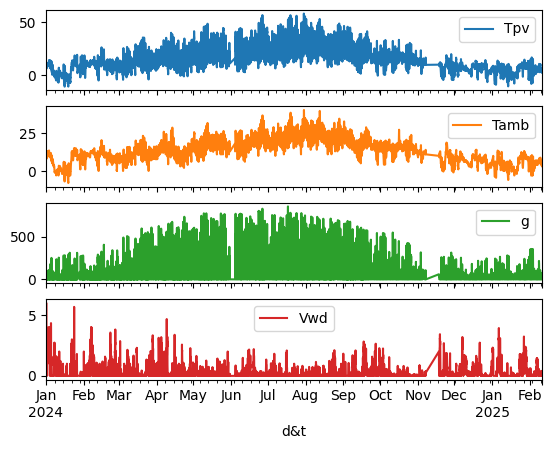

In [8]:
df_resampled.plot(subplots=True)

There are two things we have done to create a suitable dataset for our experiments: <br>
1) <strong>Resampling:</strong> By resampling the data to regular 1 hour intervals, the dataset will be organized and able to be used for training Machine Learning models. <br>
2) <strong>Interpolation:</strong> Since the time intervals of the original data were irregular, some rows with 'NULL' values were created after the resampling process since there were more than an hour between some data values. To fix this, the dataset was interpolated to fill the 'NULL' values with rough estimates.

# Adjusting the Data (PVGIS)

In [ ]:
# Reading the datasets and creating the dataframes
# Change the skiprows and skipfooter depending on the length of your .csv file
dataset = pd.read_csv("PVGIS_2023.csv", skiprows=8, skipfooter=10, engine='python') # Change to your actual file path
df_Compiegne = pd.DataFrame(dataset)

print(df_Compiegne.head())

            time  G(i)  H_sun    T2m  WS10m  Int
0  20220101:0010   0.0    0.0  10.99   2.55  0.0
1  20220101:0110   0.0    0.0  11.01   2.41  0.0
2  20220101:0210   0.0    0.0  11.09   2.21  0.0
3  20220101:0310   0.0    0.0  11.05   2.14  0.0
4  20220101:0410   0.0    0.0  10.80   2.34  0.0


In [ ]:
df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_Compiegne = df_Compiegne.set_index(['time'])

df_Compiegne_Temp = df_Compiegne.iloc[:, [0, 2]] # Features to be predicted/trained on

print(df_Compiegne_Temp.head())

                     G(i)    T2m
time                            
2022-01-01 00:10:00   0.0  10.99
2022-01-01 01:10:00   0.0  11.01
2022-01-01 02:10:00   0.0  11.09
2022-01-01 03:10:00   0.0  11.05
2022-01-01 04:10:00   0.0  10.80


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_21060\3955026766.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)


In [11]:
df_Compiegne_Temp = df_Compiegne_Temp.dropna()

In [12]:
print(np.shape(df_Compiegne_Temp))

(17520, 2)


# Necessary Functions

In [13]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0]) # Whichever feature needs to be predicted
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [ ]:
# Main forecasting function
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	# data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]

	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [ ]:
# Reframe the datasets into adjusted lengths to later convert them into supervized datasets
def reframe_datasets(training, n_input):

	# restructure into windows of hourly data
	train = array(np.split(training, len(training)/n_input))

	return train

In [16]:
# train the model
def build_model(train, n_input, n_output):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_output)

	# define parameters
	verbose, epochs, batch_size = 2, 100, 72
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(256, activation='tanh', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='tanh', return_sequences=True))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [ ]:
# evaluate a single model
def evaluate_model(model, train, test, n_input, scaler, n_output):

	# history is a list of daily data
	history = [x for x in train]

	history = np.array(history)

	history = history.reshape((history.shape[0]*history.shape[1], history.shape[2]))

	# Reshape `test` before inverse transform
	n_samples, n_features = np.shape(test)
	test_reshaped = test.reshape(n_samples, n_features)

	# walk-forward validation over each day
	predictions = list()

	i = 0

	while (i < len(test_reshaped)):

		# predict the day
		yhat_sequence = forecast(model, history, n_input)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history = np.append(history, test_reshaped[i:i+len(yhat_sequence),:], axis=0)

		# Calculate completion percentage
		completion_rate = (i + 1) / len(test_reshaped) * 100

		# Print progress on the same line
		print(f'\r{completion_rate:.0f}% complete', end='', flush=True)

		i += n_output

	# evaluate predictions hours for each day
	predictions = array(predictions)

	# Reshape `predictions` before inverse transform
	n_samples, n_timesteps, n_features = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples * n_timesteps, n_features)
	
    # Create a scaler for the target feature only
	target_scaler = MinMaxScaler(feature_range=(0, 1))
	
    # Initialize its internal parameters using the ones from the full scaler
	# The scaler must belong to the targeted feature's column
	target_scaler.min_ = scaler.min_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.scale_ = scaler.scale_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.data_min_ = scaler.data_min_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.data_max_ = scaler.data_max_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.data_range_ = scaler.data_range_[0].reshape(1,) # Change 0 to desired feature's index

	predictions_reshaped = target_scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples, n_timesteps, n_features)

	n_samples, n_features = np.shape(test)
	test_reshaped = scaler.inverse_transform(test_reshaped)
		
	test = test_reshaped.reshape(n_samples, n_features)

	return predictions, test

# 23 June 2024 - LSTM Forecasting

In [ ]:
# Select the features to train the model on
df_resampled_tamb = df_resampled['Tamb']
df_resampled_g = df_resampled['g']

# Select the features to predict with the model
df_Compiegne_tamb = df_Compiegne['T2m']
df_Compiegne_g = df_Compiegne['G(i)']

In [ ]:
# Change the following variables depending on how many predictions you want/how many previous timesteps to consider
n_input = 336 # How many past real values (timesteps) to consider while predicting the next outputs
n_output = 24 # How many future timesteps to predict

Ambient temperature is predicted first.

In [ ]:
# Training data - The date interval can be chosen as desired, but it is necessary for its structure to be similar
train_df = df_Compiegne_tamb[(df_Compiegne_tamb.index < '2023-06-23') & (df_Compiegne_tamb.index >= '2023-01-06')]
train_df = train_df.to_frame()

# Testing data - The date interval can be chosen as desired, but it is necessary for its structure to be similar
test_df = df_resampled_tamb[(df_resampled_tamb.index < '2024-06-24') & (df_resampled_tamb.index >= '2024-06-23')]
test_df = test_df.to_frame()

In [23]:
print(np.shape(train_df))
print(np.shape(test_df))

(4032, 1)
(24, 1)


In [ ]:
# Preparing dataset for LSTM training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input) # Use the training data to convert into supervised dataset later
test = df_lstm_testing

In [518]:
model = build_model(train, n_input, n_output)

Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 - 53s - 1s/step - loss: 0.0266
Epoch 2/100
52/52 - 49s - 945ms/step - loss: 0.0119
Epoch 3/100
52/52 - 50s - 956ms/step - loss: 0.0112
Epoch 4/100
52/52 - 48s - 929ms/step - loss: 0.0110
Epoch 5/100
52/52 - 49s - 944ms/step - loss: 0.0106
Epoch 6/100
52/52 - 48s - 923ms/step - loss: 0.0092
Epoch 7/100
52/52 - 48s - 932ms/step - loss: 0.0068
Epoch 8/100
52/52 - 48s - 927ms/step - loss: 0.0046
Epoch 9/100
52/52 - 49s - 948ms/step - loss: 0.0044
Epoch 10/100
52/52 - 48s - 927ms/step - loss: 0.0044
Epoch 11/100
52/52 - 48s - 930ms/step - loss: 0.0043
Epoch 12/100
52/52 - 48s - 929ms/step - loss: 0.0042
Epoch 13/100
52/52 - 48s - 931ms/step - loss: 0.0041
Epoch 14/100
52/52 - 48s - 928ms/step - loss: 0.0041
Epoch 15/100
52/52 - 49s - 938ms/step - loss: 0.0040
Epoch 16/100
52/52 - 48s - 919ms/step - loss: 0.0040
Epoch 17/100
52/52 - 48s - 914ms/step - loss: 0.0040
Epoch 18/100
52/52 - 48s - 923ms/step - loss: 0.0039
Epoch 19/100
52/52 - 49s - 948ms/step - loss: 0.0039
Epoch 20/100
52/5

In [521]:
# Evaluate model and get scores
predictions_tamb, test = evaluate_model(model, train, test, n_input, scaler, n_output)

4% complete

In [ ]:
flattened_predictions_tamb = predictions_tamb.flatten()

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_df['Tamb'].values, flattened_predictions_tamb)) # Change the column name for different predictions
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.542


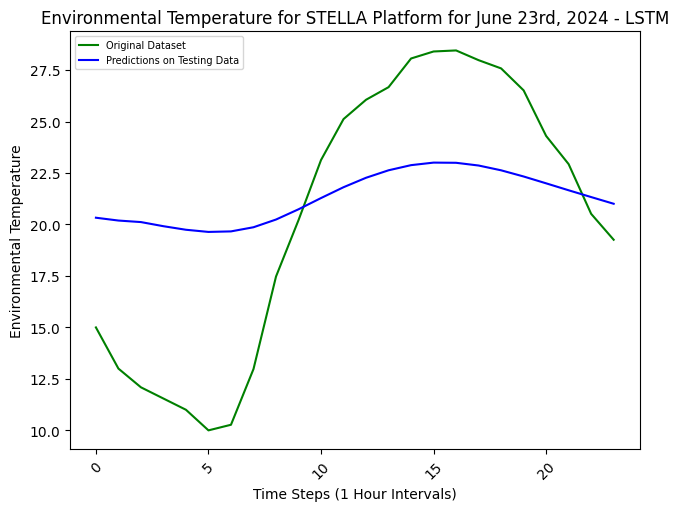

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['Tamb'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(flattened_predictions_tamb, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for June 23rd, 2024 - LSTM')
plt.show()

After ambient temperature, model for solar irradiance is trained and irradiance is predicted.

In [439]:
# Training data
train_df = df_Compiegne_g[(df_Compiegne_g.index < '2023-06-23') & (df_Compiegne_g.index >= '2023-01-06')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_g[(df_resampled_g.index < '2024-06-24') & (df_resampled_g.index >= '2024-06-23')]
test_df = test_df.to_frame()

In [440]:
print(np.shape(train_df))
print(np.shape(test_df))

(4032, 1)
(24, 1)


In [ ]:
# Preparing dataset for LSTM training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

In [410]:
model = build_model(train, n_input, n_output)

Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 - 29s - 533ms/step - loss: 0.0517
Epoch 2/100
54/54 - 25s - 465ms/step - loss: 0.0224
Epoch 3/100
54/54 - 24s - 450ms/step - loss: 0.0202
Epoch 4/100
54/54 - 25s - 458ms/step - loss: 0.0192
Epoch 5/100
54/54 - 25s - 462ms/step - loss: 0.0186
Epoch 6/100
54/54 - 25s - 462ms/step - loss: 0.0181
Epoch 7/100
54/54 - 25s - 462ms/step - loss: 0.0177
Epoch 8/100
54/54 - 24s - 453ms/step - loss: 0.0176
Epoch 9/100
54/54 - 25s - 466ms/step - loss: 0.0174
Epoch 10/100
54/54 - 25s - 465ms/step - loss: 0.0173
Epoch 11/100
54/54 - 25s - 459ms/step - loss: 0.0172
Epoch 12/100
54/54 - 25s - 461ms/step - loss: 0.0172
Epoch 13/100
54/54 - 25s - 465ms/step - loss: 0.0171
Epoch 14/100
54/54 - 24s - 453ms/step - loss: 0.0170
Epoch 15/100
54/54 - 25s - 456ms/step - loss: 0.0169
Epoch 16/100
54/54 - 26s - 476ms/step - loss: 0.0169
Epoch 17/100
54/54 - 25s - 457ms/step - loss: 0.0168
Epoch 18/100
54/54 - 24s - 452ms/step - loss: 0.0167
Epoch 19/100
54/54 - 25s - 460ms/step - loss: 0.0166
Epoch 20/100
5

In [411]:
# Evaluate model and get scores
predictions_g, test = evaluate_model(model, train, test, n_input, scaler, n_output)

4% complete

In [ ]:
flattened_predictions_g = predictions_g.flatten()

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_df['g'].values, flattened_predictions_g)) # Change the column name for different predictions
print('Test RMSE: %.3f' % rmse)

Test RMSE: 167.920


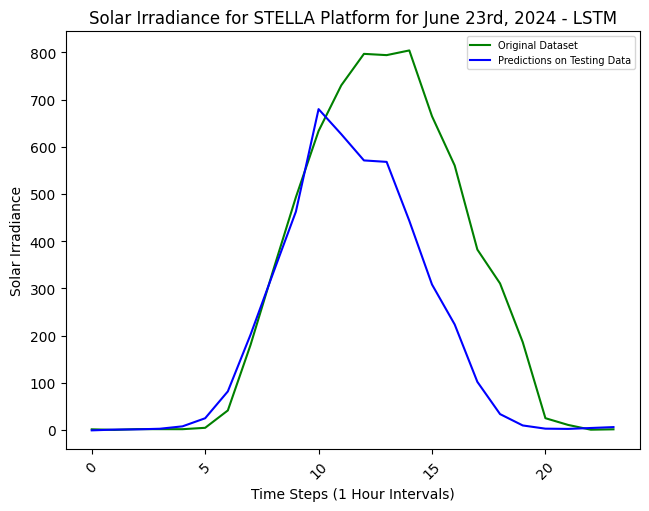

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['g'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(flattened_predictions_g, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Irradiance')
plt.title('Solar Irradiance for STELLA Platform for June 23rd, 2024 - LSTM')
plt.show()

In [ ]:
# Output the results into a text file
start_time = datetime.strptime("00:00:00", "%H:%M:%S")
time_interval = timedelta(minutes=60) # Should be the same as the resampling interval

with open("23062024-LSTM.txt", "w") as f: # Change the name of the text file depending on the day
    for i in range(n_output): 
        current_time = (start_time + i * time_interval).strftime("%H:%M:%S")
        line = f"{current_time},{flattened_predictions_tamb[i]},{flattened_predictions_g[i]}\n"
        f.write(line)

# 23 June 2024 Forecasting - ARIMA

In [418]:
df_resampled_tamb = df_resampled['Tamb']
df_resampled_g = df_resampled['g']

df_Compiegne_tamb = df_Compiegne['T2m']
df_Compiegne_g = df_Compiegne['G(i)']

Ambient temperature is predicted first.

In [419]:
# Training data
train_df = df_Compiegne_tamb[(df_Compiegne_tamb.index < '2023-06-23') & (df_Compiegne_tamb.index >= '2023-01-06')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_tamb[(df_resampled_tamb.index < '2024-06-24') & (df_resampled_tamb.index >= '2024-06-23')]
test_df = test_df.to_frame()

In [420]:
print(np.shape(train_df))
print(np.shape(test_df))

(4032, 1)
(24, 1)


In [ ]:
# Preparing dataset for ARIMA training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

## Plotting the Column and Summarizing the Model
This part is not necessary to run for the model to work.

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(test_df, label='Temperature')

# Set major x-axis locator to show only 4 dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=4))  # Force 4 labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD-HH-mm'
plt.xlabel("Date")
plt.ylabel("Environmental Temperature")
plt.legend()
plt.tight_layout()
plt.show()

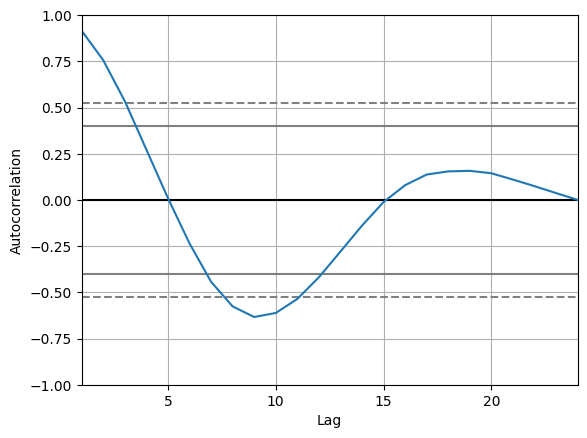

In [ ]:
autocorrelation_plot(test_df)
plt.show()

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      g   No. Observations:                   24
Model:                ARIMA(24, 1, 0)   Log Likelihood                -110.804
Date:                Thu, 01 May 2025   AIC                            271.608
Time:                        00:56:42   BIC                            299.995
Sample:                    06-23-2024   HQIC                           278.747
                         - 06-23-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486     29.848      0.012      0.991     -58.153      58.850
ar.L2          1.3555     48.273      0.028      0.978     -93.258      95.969
ar.L3         -0.3196     44.815     -0.007      0.9

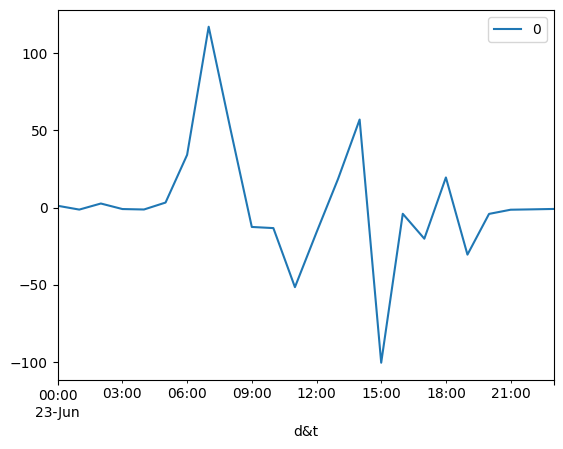

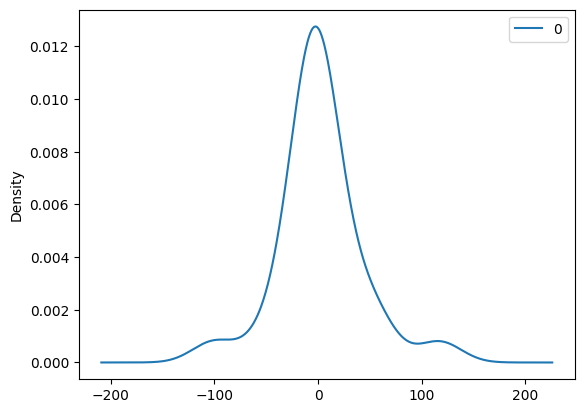

                0
count   24.000000
mean     1.946522
std     39.652520
min   -100.420276
25%    -12.674357
50%     -1.136278
75%      7.143871
max    117.190561


In [ ]:
# fit model
model_arima = ARIMA(test_df, order=(24,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

## Forecasting

In [ ]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = n_output
n_steps = n_input
percentage = 0

model_arima = ARIMA(history_arima, order=(n_steps,0,0))
model_fit = model_arima.fit()

# walk-forward validation
while check:

	# Forecast n_forecast steps ahead
	output_arima = model_fit.forecast(steps=n_forecast)
	yhat_arima = output_arima[:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for next n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_fit = model_fit.append(actual_values, refit=False)

	# Compute RMSE for these 7 predictions
	multiple_rmse = np.sqrt(np.mean((yhat_arima - actual_values) ** 2))
	rmse_per_prediction.append(multiple_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted 24 steps ahead | RMSE=0.383105 | 100% complete


In [ ]:
# evaluate predictions hours for each day
predictions_arima = array(predictions_arima)

# Reshape `predictions` before inverse transform
n_samples = predictions_arima.shape
predictions_arima_tamb = predictions_arima.reshape(n_samples[0] * 1, 1)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler.min_[0].reshape(1,) # Change 0 to desired feature's index
target_scaler.scale_ = scaler.scale_[0].reshape(1,) # Change 0 to desired feature's index
target_scaler.data_min_ = scaler.data_min_[0].reshape(1,) # Change 0 to desired feature's index
target_scaler.data_max_ = scaler.data_max_[0].reshape(1,) # Change 0 to desired feature's index
target_scaler.data_range_ = scaler.data_range_[0].reshape(1,) # Change 0 to desired feature's index

predictions_arima_tamb = target_scaler.inverse_transform(predictions_arima_tamb)

test_reshaped = scaler.inverse_transform(test_arima)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_reshaped, predictions_arima_tamb))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.647


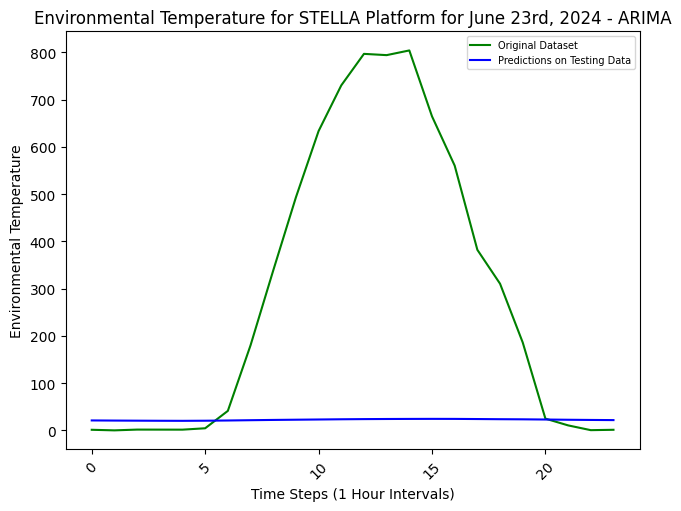

In [ ]:
# Plot baseline and predictions

plt.plot(test_df.values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(predictions_arima_tamb, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for June 23rd, 2024 - ARIMA')
plt.show()

After ambient temperature, model for solar irradiance is trained and irradiance is predicted.

In [ ]:
# Training data
train_df = df_Compiegne_g[(df_Compiegne_g.index < '2023-06-23') & (df_Compiegne_g.index >= '2023-01-06')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_g[(df_resampled_g.index < '2024-06-24') & (df_resampled_g.index >= '2024-06-23')]
test_df = test_df.to_frame()

In [ ]:
print(np.shape(train_df))
print(np.shape(test_df))

(4032, 1)
(24, 1)


In [ ]:
# Preparing dataset for ARIMA training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

In [ ]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = n_output
n_steps = n_input
percentage = 0

model_arima = ARIMA(history_arima, order=(n_steps,0,24))
model_fit = model_arima.fit()

# walk-forward validation
while check:

	# Forecast n_forecast steps ahead
	output_arima = model_fit.forecast(steps=n_forecast)
	yhat_arima = output_arima[:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for next n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_fit = model_fit.append(actual_values, refit=False)

	# Compute RMSE for these 7 predictions
	multiple_rmse = np.sqrt(np.mean((yhat_arima - actual_values) ** 2))
	rmse_per_prediction.append(multiple_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False


In [ ]:
# evaluate predictions hours for each day
predictions_arima = array(predictions_arima)

# Reshape `predictions` before inverse transform
n_samples = predictions_arima.shape
predictions_arima_g = predictions_arima.reshape(n_samples[0] * 1, 1)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler.min_[0].reshape(1,)
target_scaler.scale_ = scaler.scale_[0].reshape(1,)
target_scaler.data_min_ = scaler.data_min_[0].reshape(1,)
target_scaler.data_max_ = scaler.data_max_[0].reshape(1,)
target_scaler.data_range_ = scaler.data_range_[0].reshape(1,)

predictions_arima_g = target_scaler.inverse_transform(predictions_arima_g)

test_reshaped = scaler.inverse_transform(test_arima)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_reshaped, predictions_arima_g))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 210.209


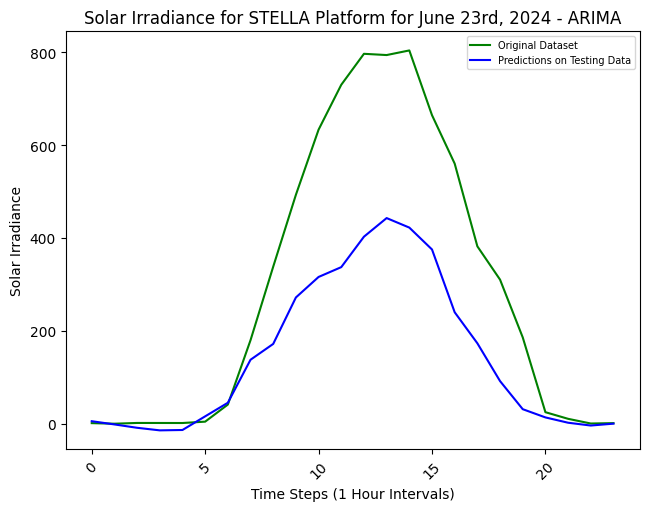

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['g'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(predictions_arima_g, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Irradiance')
plt.title('Solar Irradiance for STELLA Platform for June 23rd, 2024 - ARIMA')
plt.show()

In [ ]:
# Output the results into a text file
start_time = datetime.strptime("00:00:00", "%H:%M:%S")
time_interval = timedelta(minutes=60) # Should be the same as the resampling interval

with open("23062024-ARIMA.txt", "w") as f: # Change the name of the text file depending on the day
    for i in range(n_output):
        current_time = (start_time + i * time_interval).strftime("%H:%M:%S")
        line = f"{current_time},{predictions_arima_tamb[i][0]},{predictions_arima_g[i][0]}\n"
        f.write(line)

# 26 July 2024 - LSTM Forecasting

In [464]:
df_resampled_tamb = df_resampled['Tamb']
df_resampled_g = df_resampled['g']

df_Compiegne_tamb = df_Compiegne['T2m']
df_Compiegne_g = df_Compiegne['G(i)']

Ambient temperature is predicted first.

In [465]:
# Training data
train_df = df_Compiegne_tamb[(df_Compiegne_tamb.index < '2023-07-26') & (df_Compiegne_tamb.index >= '2023-02-08')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_tamb[(df_resampled_tamb.index < '2024-07-27') & (df_resampled_tamb.index >= '2024-07-26')]
test_df = test_df.to_frame()

In [466]:
print(np.shape(train_df))
print(np.shape(test_df))

(4032, 1)
(24, 1)


In [ ]:
# Preparing dataset for LSTM training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

In [468]:
model = build_model(train, n_input, n_output)

Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 - 28s - 516ms/step - loss: 0.0284
Epoch 2/100
54/54 - 23s - 427ms/step - loss: 0.0118
Epoch 3/100
54/54 - 23s - 422ms/step - loss: 0.0111
Epoch 4/100
54/54 - 24s - 438ms/step - loss: 0.0108
Epoch 5/100
54/54 - 23s - 433ms/step - loss: 0.0106
Epoch 6/100
54/54 - 23s - 428ms/step - loss: 0.0079
Epoch 7/100
54/54 - 23s - 424ms/step - loss: 0.0049
Epoch 8/100
54/54 - 23s - 431ms/step - loss: 0.0043
Epoch 9/100
54/54 - 23s - 425ms/step - loss: 0.0042
Epoch 10/100
54/54 - 23s - 429ms/step - loss: 0.0041
Epoch 11/100
54/54 - 23s - 432ms/step - loss: 0.0040
Epoch 12/100
54/54 - 23s - 434ms/step - loss: 0.0039
Epoch 13/100
54/54 - 24s - 446ms/step - loss: 0.0038
Epoch 14/100
54/54 - 23s - 433ms/step - loss: 0.0037
Epoch 15/100
54/54 - 24s - 439ms/step - loss: 0.0036
Epoch 16/100
54/54 - 24s - 444ms/step - loss: 0.0035
Epoch 17/100
54/54 - 23s - 435ms/step - loss: 0.0035
Epoch 18/100
54/54 - 24s - 442ms/step - loss: 0.0034
Epoch 19/100
54/54 - 24s - 441ms/step - loss: 0.0034
Epoch 20/100
5

In [469]:
# Evaluate model and get scores
predictions_tamb, test = evaluate_model(model, train, test, n_input, scaler, n_output)

4% complete

In [ ]:
flattened_predictions_tamb = predictions_tamb.flatten()

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_df['Tamb'].values, flattened_predictions_tamb)) # Change the column name for different predictions
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.530


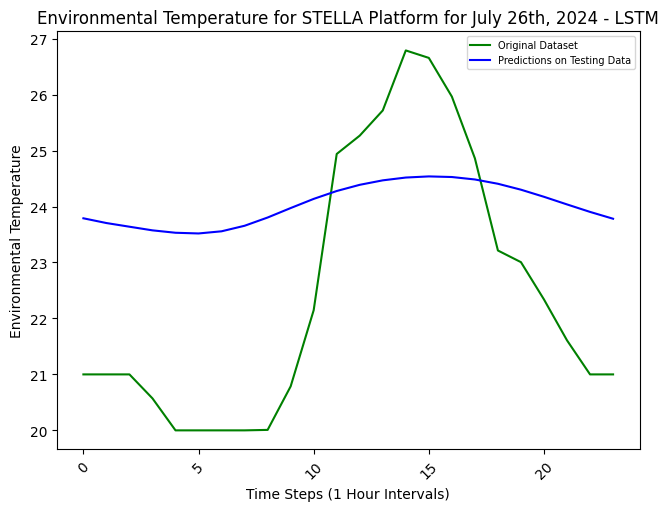

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['Tamb'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(flattened_predictions_tamb, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for July 26th, 2024 - LSTM')
plt.show()

After ambient temperature, model for solar irradiance is trained and irradiance is predicted.

In [472]:
# Training data
train_df = df_Compiegne_g[(df_Compiegne_g.index < '2023-07-26') & (df_Compiegne_g.index >= '2023-02-08')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_g[(df_resampled_g.index < '2024-07-27') & (df_resampled_g.index >= '2024-07-26')]
test_df = test_df.to_frame()

In [473]:
print(np.shape(train_df))
print(np.shape(test_df))

(4032, 1)
(24, 1)


In [ ]:
# Preparing dataset for LSTM training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

In [475]:
model = build_model(train, n_input, n_output)

Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 - 28s - 519ms/step - loss: 0.0581
Epoch 2/100
54/54 - 22s - 415ms/step - loss: 0.0245
Epoch 3/100
54/54 - 22s - 410ms/step - loss: 0.0214
Epoch 4/100
54/54 - 22s - 416ms/step - loss: 0.0206
Epoch 5/100
54/54 - 24s - 436ms/step - loss: 0.0201
Epoch 6/100
54/54 - 24s - 440ms/step - loss: 0.0193
Epoch 7/100
54/54 - 23s - 424ms/step - loss: 0.0190
Epoch 8/100
54/54 - 23s - 419ms/step - loss: 0.0189
Epoch 9/100
54/54 - 23s - 424ms/step - loss: 0.0187
Epoch 10/100
54/54 - 23s - 425ms/step - loss: 0.0187
Epoch 11/100
54/54 - 23s - 425ms/step - loss: 0.0191
Epoch 12/100
54/54 - 23s - 425ms/step - loss: 0.0185
Epoch 13/100
54/54 - 23s - 428ms/step - loss: 0.0184
Epoch 14/100
54/54 - 23s - 418ms/step - loss: 0.0182
Epoch 15/100
54/54 - 23s - 426ms/step - loss: 0.0181
Epoch 16/100
54/54 - 23s - 422ms/step - loss: 0.0180
Epoch 17/100
54/54 - 22s - 415ms/step - loss: 0.0179
Epoch 18/100
54/54 - 22s - 413ms/step - loss: 0.0178
Epoch 19/100
54/54 - 24s - 439ms/step - loss: 0.0177
Epoch 20/100
5

In [476]:
# Evaluate model and get scores
predictions_g, test = evaluate_model(model, train, test, n_input, scaler, n_output)

4% complete

In [ ]:
flattened_predictions_g = predictions_g.flatten()

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_df['g'].values, flattened_predictions_g)) # Change the column name for different predictions
print('Test RMSE: %.3f' % rmse)

Test RMSE: 96.960


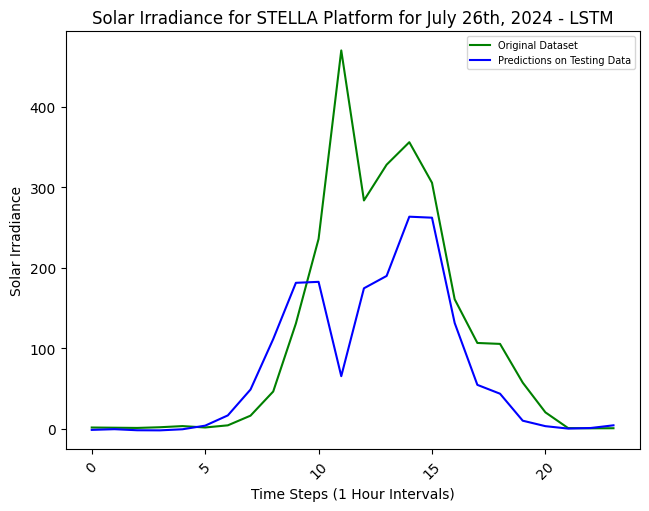

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['g'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(flattened_predictions_g, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Irradiance')
plt.title('Solar Irradiance for STELLA Platform for July 26th, 2024 - LSTM')
plt.show()

In [ ]:
# Output the results into a text file
start_time = datetime.strptime("00:00:00", "%H:%M:%S")
time_interval = timedelta(minutes=60) # Should be the same as the resampling interval

with open("26072024-LSTM.txt", "w") as f: # Change the name of the text file depending on the day
    for i in range(n_output):
        current_time = (start_time + i * time_interval).strftime("%H:%M:%S")
        line = f"{current_time},{flattened_predictions_tamb[i]},{flattened_predictions_g[i]}\n"
        f.write(line)

# 26 July 2024 Forecasting - ARIMA

In [ ]:
df_resampled_tamb = df_resampled['Tamb']
df_resampled_g = df_resampled['g']

df_Compiegne_tamb = df_Compiegne['T2m']
df_Compiegne_g = df_Compiegne['G(i)']

Ambient temperature is predicted first.

In [ ]:
# Training data
train_df = df_Compiegne_tamb[(df_Compiegne_tamb.index < '2023-07-26') & (df_Compiegne_tamb.index >= '2023-02-08')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_tamb[(df_resampled_tamb.index < '2024-07-27') & (df_resampled_tamb.index >= '2024-07-26')]
test_df = test_df.to_frame()

In [ ]:
print(np.shape(train_df))
print(np.shape(test_df))

(4128, 1)
(48, 1)


In [ ]:
# Preparing dataset for ARIMA training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

## Plotting the Column and Summarizing the Model
This part is not necessary to run for the model to work.

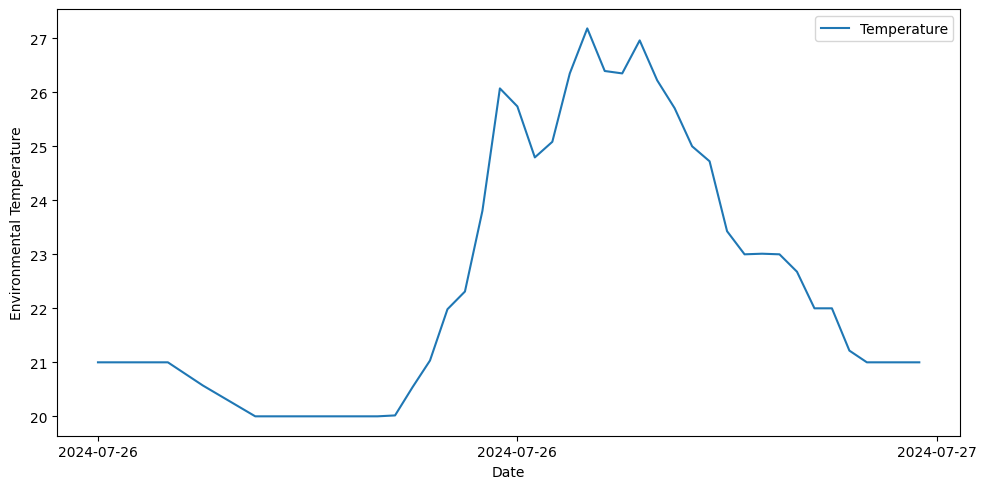

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(test_df, label='Temperature')

# Set major x-axis locator to show only 4 dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=4))  # Force 4 labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD-HH-mm'
plt.xlabel("Date")
plt.ylabel("Environmental Temperature")
plt.legend()
plt.tight_layout()
plt.show()

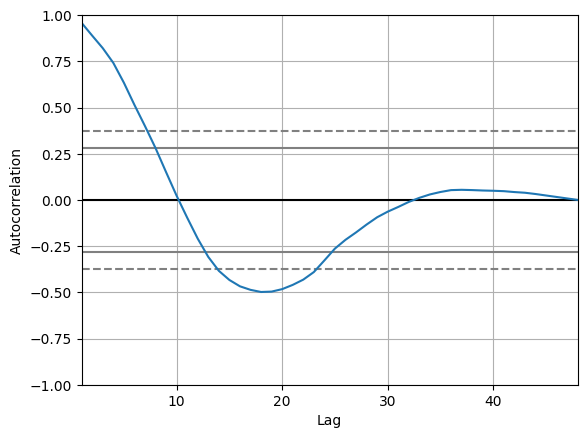

In [ ]:
autocorrelation_plot(test_df)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   Tamb   No. Observations:                   48
Model:                 ARIMA(6, 1, 0)   Log Likelihood                 -34.827
Date:                Mon, 28 Apr 2025   AIC                             83.653
Time:                        17:15:51   BIC                             96.604
Sample:                    07-26-2024   HQIC                            88.527
                         - 07-26-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4312      0.107      4.038      0.000       0.222       0.641
ar.L2         -0.1978      0.138     -1.430      0.153      -0.469       0.073
ar.L3          0.2040      0.181      1.129      0.2

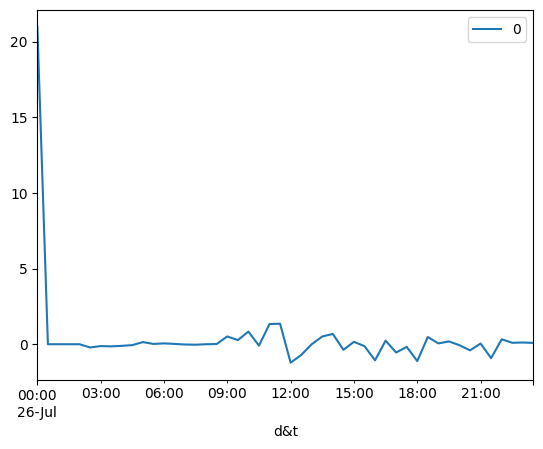

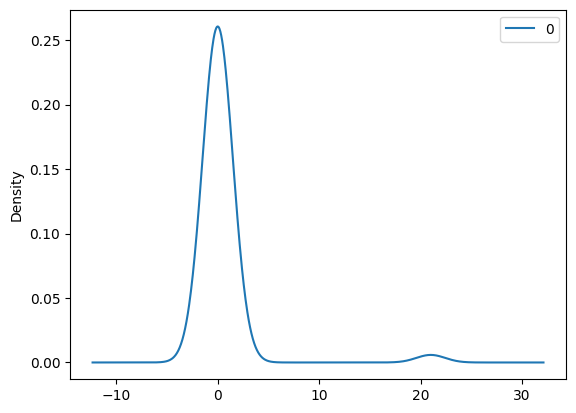

               0
count  48.000000
mean    0.438479
std     3.072374
min    -1.222867
25%    -0.123248
50%     0.000476
75%     0.166437
max    21.000000


In [ ]:
# fit model
model_arima = ARIMA(test_df, order=(24,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

## Forecasting

In [ ]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = n_output
n_steps = n_input
percentage = 0

model_arima = ARIMA(history_arima, order=(n_steps,0,0))
model_fit = model_arima.fit()

# walk-forward validation
while check:

	# Forecast n_forecast steps ahead
	output_arima = model_fit.forecast(steps=n_forecast)
	yhat_arima = output_arima[:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for next n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_fit = model_fit.append(actual_values, refit=False)

	# Compute RMSE for these 7 predictions
	multiple_rmse = np.sqrt(np.mean((yhat_arima - actual_values) ** 2))
	rmse_per_prediction.append(multiple_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False


Predicted 48 steps ahead | RMSE=0.392754 | 100% complete


In [ ]:
# evaluate predictions hours for each day
predictions_arima = array(predictions_arima)

# Reshape `predictions` before inverse transform
n_samples = predictions_arima.shape
predictions_arima_tamb = predictions_arima.reshape(n_samples[0] * 1, 1)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler.min_[0].reshape(1,)
target_scaler.scale_ = scaler.scale_[0].reshape(1,)
target_scaler.data_min_ = scaler.data_min_[0].reshape(1,)
target_scaler.data_max_ = scaler.data_max_[0].reshape(1,)
target_scaler.data_range_ = scaler.data_range_[0].reshape(1,)

predictions_arima_tamb = target_scaler.inverse_transform(predictions_arima_tamb)

test_reshaped = scaler.inverse_transform(test_arima)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_reshaped, predictions_arima_tamb))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.100


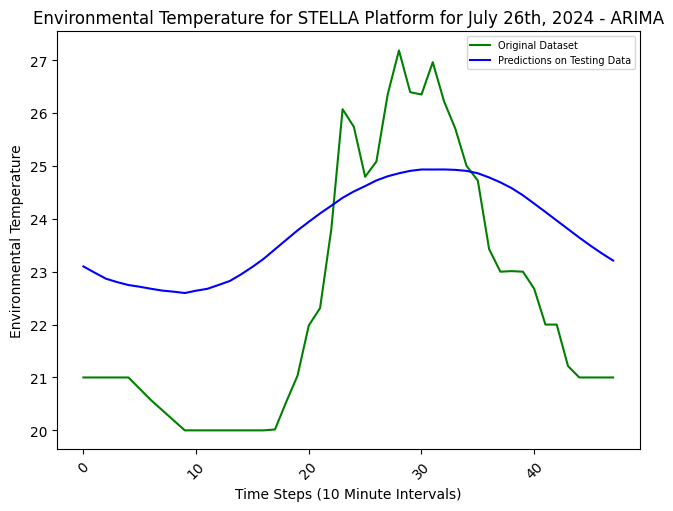

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['Tamb'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(predictions_arima_tamb, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for July 26th, 2024 - ARIMA')
plt.show()

After ambient temperature, model for solar irradiance is trained and irradiance is predicted.

In [ ]:
# Training data
train_df = df_Compiegne_g[(df_Compiegne_g.index < '2023-07-26') & (df_Compiegne_g.index >= '2023-02-08')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_g[(df_resampled_g.index < '2024-07-27') & (df_resampled_g.index >= '2024-07-26')]
test_df = test_df.to_frame()

In [ ]:
print(np.shape(train_df))
print(np.shape(test_df))

(4128, 1)
(48, 1)


In [ ]:
# Preparing dataset for ARIMA training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

In [ ]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = n_output
n_steps = n_input
percentage = 0

model_arima = ARIMA(history_arima, order=(n_steps,0,0))
model_fit = model_arima.fit()

# walk-forward validation
while check:

	# Forecast n_forecast steps ahead
	output_arima = model_fit.forecast(steps=n_forecast)
	yhat_arima = output_arima[:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for next n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_fit = model_fit.append(actual_values, refit=False)

	# Compute RMSE for these 7 predictions
	multiple_rmse = np.sqrt(np.mean((yhat_arima - actual_values) ** 2))
	rmse_per_prediction.append(multiple_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False


Predicted 48 steps ahead | RMSE=0.351186 | 100% complete


In [ ]:
# evaluate predictions hours for each day
predictions_arima = array(predictions_arima)

# Reshape `predictions` before inverse transform
n_samples = predictions_arima.shape
predictions_arima_g = predictions_arima.reshape(n_samples[0] * 1, 1)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler.min_[0].reshape(1,)
target_scaler.scale_ = scaler.scale_[0].reshape(1,)
target_scaler.data_min_ = scaler.data_min_[0].reshape(1,)
target_scaler.data_max_ = scaler.data_max_[0].reshape(1,)
target_scaler.data_range_ = scaler.data_range_[0].reshape(1,)

predictions_arima_g = target_scaler.inverse_transform(predictions_arima_g)

test_reshaped = scaler.inverse_transform(test_arima)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_reshaped, predictions_arima_g))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 62.341


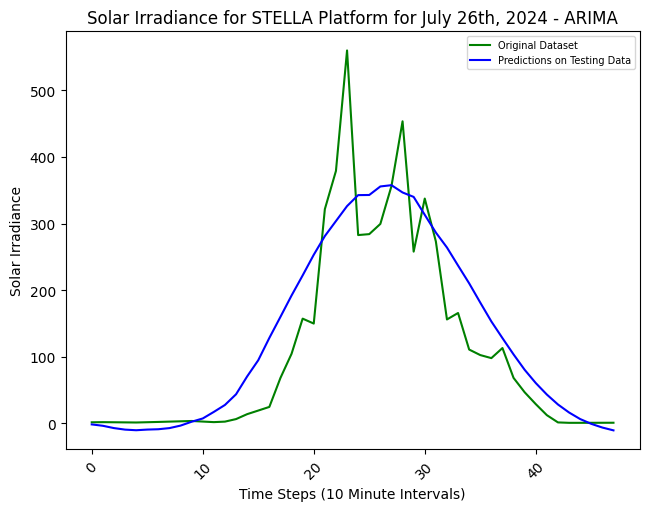

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['g'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(predictions_arima_g, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Irradiance')
plt.title('Solar Irradiance for STELLA Platform for July 26th, 2024 - ARIMA')
plt.show()

In [ ]:
# Output the results into a text file
start_time = datetime.strptime("00:00:00", "%H:%M:%S")
time_interval = timedelta(minutes=60) # Should be the same as the resampling interval

with open("26072024-ARIMA.txt", "w") as f: # Change the name of the text file depending on the day
    for i in range(n_output):
        current_time = (start_time + i * time_interval).strftime("%H:%M:%S")
        line = f"{current_time},{predictions_arima_tamb[i][0]},{predictions_arima_g[i][0]}\n"
        f.write(line)

# 06 November 2024 - LSTM Forecasting

In [480]:
df_resampled_tamb = df_resampled['Tamb']
df_resampled_g = df_resampled['g']

df_Compiegne_tamb = df_Compiegne['T2m']
df_Compiegne_g = df_Compiegne['G(i)']

Ambient temperature is predicted first.

In [481]:
# Training data
train_df = df_Compiegne_tamb[(df_Compiegne_tamb.index < '2023-09-06') & (df_Compiegne_tamb.index >= '2023-03-22')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_tamb[(df_resampled_tamb.index < '2024-09-07') & (df_resampled_tamb.index >= '2024-09-06')]
test_df = test_df.to_frame()

In [482]:
print(np.shape(train_df))
print(np.shape(test_df))

(4032, 1)
(24, 1)


In [ ]:
# Preparing dataset for ARIMA training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

In [484]:
model = build_model(train, n_input, n_output)

Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 - 27s - 491ms/step - loss: 0.0302
Epoch 2/100
54/54 - 22s - 411ms/step - loss: 0.0143
Epoch 3/100
54/54 - 22s - 400ms/step - loss: 0.0135
Epoch 4/100
54/54 - 22s - 408ms/step - loss: 0.0134
Epoch 5/100
54/54 - 22s - 402ms/step - loss: 0.0088
Epoch 6/100
54/54 - 22s - 410ms/step - loss: 0.0049
Epoch 7/100
54/54 - 22s - 404ms/step - loss: 0.0047
Epoch 8/100
54/54 - 22s - 409ms/step - loss: 0.0046
Epoch 9/100
54/54 - 22s - 405ms/step - loss: 0.0045
Epoch 10/100
54/54 - 22s - 401ms/step - loss: 0.0044
Epoch 11/100
54/54 - 22s - 401ms/step - loss: 0.0044
Epoch 12/100
54/54 - 22s - 406ms/step - loss: 0.0044
Epoch 13/100
54/54 - 22s - 402ms/step - loss: 0.0043
Epoch 14/100
54/54 - 22s - 399ms/step - loss: 0.0043
Epoch 15/100
54/54 - 22s - 404ms/step - loss: 0.0042
Epoch 16/100
54/54 - 22s - 402ms/step - loss: 0.0042
Epoch 17/100
54/54 - 22s - 408ms/step - loss: 0.0041
Epoch 18/100
54/54 - 22s - 401ms/step - loss: 0.0041
Epoch 19/100
54/54 - 22s - 402ms/step - loss: 0.0041
Epoch 20/100
5

In [485]:
# Evaluate model and get scores
predictions_tamb, test = evaluate_model(model, train, test, n_input, scaler, n_output)

4% complete

In [ ]:
flattened_predictions_tamb = predictions_tamb.flatten()

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_df['Tamb'].values, flattened_predictions_tamb)) # Change the column name for different predictions
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.849


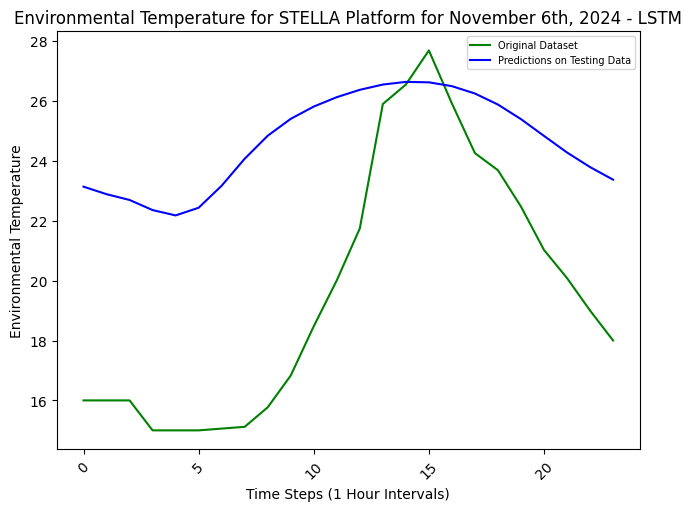

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['Tamb'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(flattened_predictions_tamb, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for November 6th, 2024 - LSTM')
plt.show()

After ambient temperature, model for solar irradiance is trained and irradiance is predicted.

In [488]:
# Training data
train_df = df_Compiegne_g[(df_Compiegne_g.index < '2023-09-06') & (df_Compiegne_g.index >= '2023-03-22')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_g[(df_resampled_g.index < '2024-09-07') & (df_resampled_g.index >= '2024-09-06')]
test_df = test_df.to_frame()

In [489]:
print(np.shape(train_df))
print(np.shape(test_df))

(4032, 1)
(24, 1)


In [ ]:
# Preparing dataset for ARIMA training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

In [491]:
model = build_model(train, n_input, n_output)

Epoch 1/100


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 - 26s - 482ms/step - loss: 0.0637
Epoch 2/100
54/54 - 22s - 401ms/step - loss: 0.0249
Epoch 3/100
54/54 - 22s - 406ms/step - loss: 0.0211
Epoch 4/100
54/54 - 22s - 412ms/step - loss: 0.0207
Epoch 5/100
54/54 - 22s - 409ms/step - loss: 0.0197
Epoch 6/100
54/54 - 22s - 408ms/step - loss: 0.0194
Epoch 7/100
54/54 - 22s - 404ms/step - loss: 0.0189
Epoch 8/100
54/54 - 22s - 407ms/step - loss: 0.0190
Epoch 9/100
54/54 - 22s - 404ms/step - loss: 0.0185
Epoch 10/100
54/54 - 22s - 410ms/step - loss: 0.0186
Epoch 11/100
54/54 - 22s - 401ms/step - loss: 0.0185
Epoch 12/100
54/54 - 22s - 409ms/step - loss: 0.0184
Epoch 13/100
54/54 - 22s - 409ms/step - loss: 0.0188
Epoch 14/100
54/54 - 22s - 402ms/step - loss: 0.0185
Epoch 15/100
54/54 - 22s - 405ms/step - loss: 0.0181
Epoch 16/100
54/54 - 22s - 403ms/step - loss: 0.0182
Epoch 17/100
54/54 - 22s - 404ms/step - loss: 0.0180
Epoch 18/100
54/54 - 22s - 398ms/step - loss: 0.0181
Epoch 19/100
54/54 - 22s - 402ms/step - loss: 0.0179
Epoch 20/100
5

In [492]:
# Evaluate model and get scores
predictions_g, test = evaluate_model(model, train, test, n_input, scaler, n_output)

4% complete

In [ ]:
flattened_predictions_g = predictions_g.flatten()

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_df['g'].values, flattened_predictions_g)) # Change the column name for different predictions
print('Test RMSE: %.3f' % rmse)

Test RMSE: 147.099


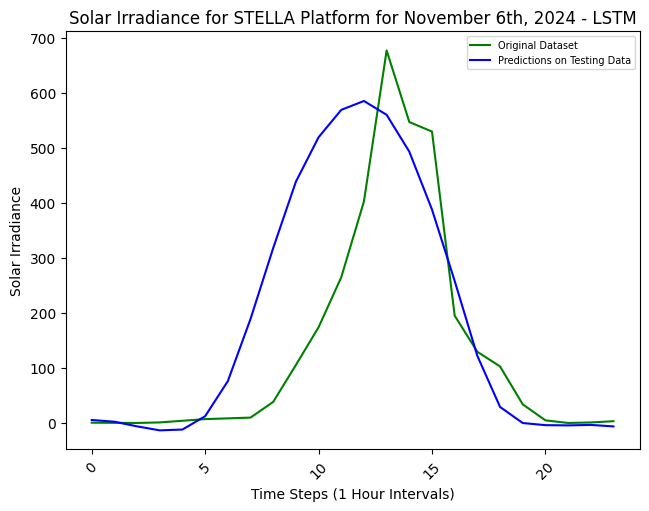

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['g'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(flattened_predictions_g, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Irradiance')
plt.title('Solar Irradiance for STELLA Platform for November 6th, 2024 - LSTM')
plt.show()

In [ ]:
# Output the results into a text file
start_time = datetime.strptime("00:00:00", "%H:%M:%S")
time_interval = timedelta(minutes=60) # Should be the same as the resampling interval

with open("06092024-LSTM.txt", "w") as f: # Change the name of the text file depending on the day
    for i in range(n_output):
        current_time = (start_time + i * time_interval).strftime("%H:%M:%S")
        line = f"{current_time},{flattened_predictions_tamb[i]},{flattened_predictions_g[i]}\n"
        f.write(line)

# 06 November 2024 Forecasting - ARIMA

In [ ]:
df_resampled_tamb = df_resampled['Tamb']
df_resampled_g = df_resampled['g']

df_Compiegne_tamb = df_Compiegne['T2m']
df_Compiegne_g = df_Compiegne['G(i)']

Ambient temperature is predicted first.

In [ ]:
# Training data
train_df = df_Compiegne_tamb[(df_Compiegne_tamb.index < '2023-09-06') & (df_Compiegne_tamb.index >= '2023-03-22')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_tamb[(df_resampled_tamb.index < '2024-09-07') & (df_resampled_tamb.index >= '2024-09-06')]
test_df = test_df.to_frame()

In [ ]:
print(np.shape(train_df))
print(np.shape(test_df))

(3216, 1)
(48, 1)


In [ ]:
# Preparing dataset for ARIMA training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

## Plotting the Column and Summarizing the Model
This part is not necessary to run for the model to work.

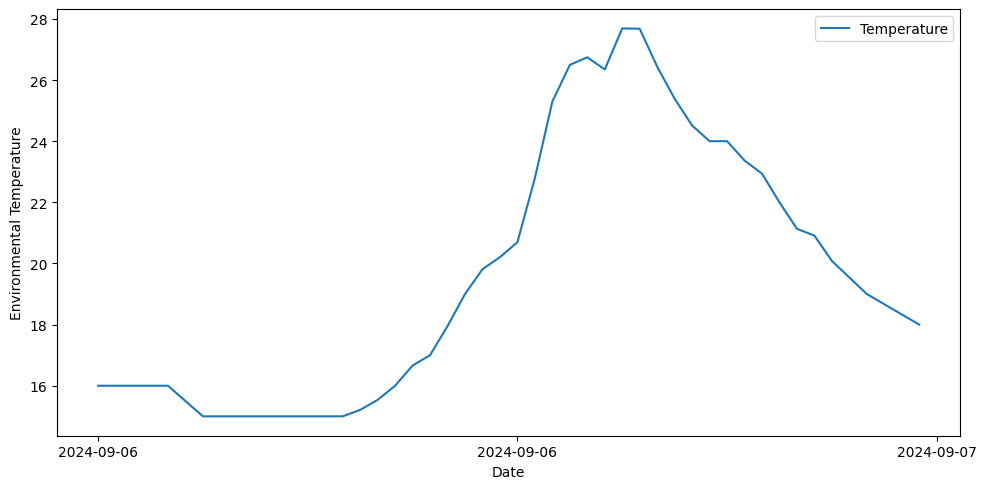

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(test_df, label='Temperature')

# Set major x-axis locator to show only 4 dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=4))  # Force 4 labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD-HH-mm'
plt.xlabel("Date")
plt.ylabel("Environmental Temperature")
plt.legend()
plt.tight_layout()
plt.show()

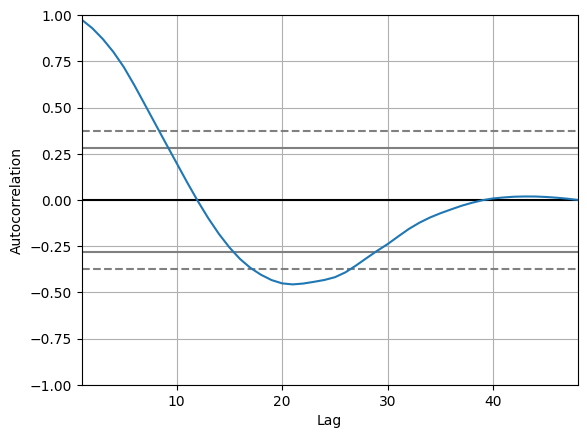

In [ ]:
autocorrelation_plot(test_df)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   Tamb   No. Observations:                   48
Model:                 ARIMA(6, 1, 0)   Log Likelihood                 -31.008
Date:                Mon, 28 Apr 2025   AIC                             76.015
Time:                        17:51:56   BIC                             88.967
Sample:                    09-06-2024   HQIC                            80.889
                         - 09-06-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7534      0.110      6.873      0.000       0.539       0.968
ar.L2         -0.1835      0.171     -1.071      0.284      -0.519       0.152
ar.L3          0.1375      0.238      0.578      0.5

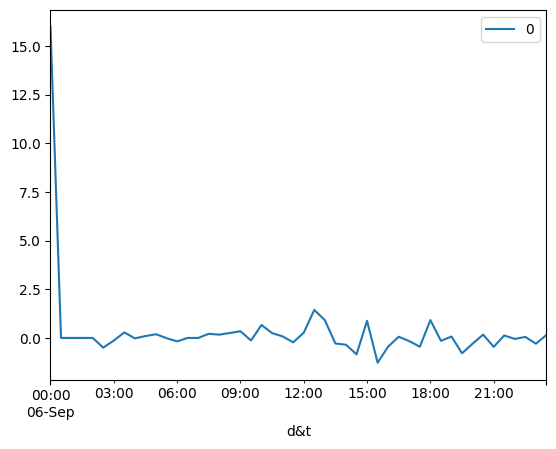

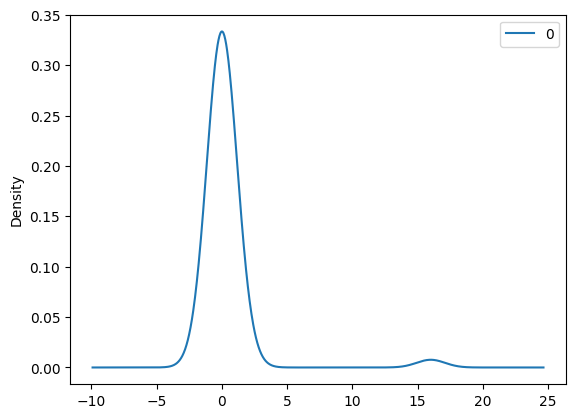

                  0
count  4.800000e+01
mean   3.441546e-01
std    2.353158e+00
min   -1.275017e+00
25%   -1.894967e-01
50%    3.170797e-13
75%    1.958406e-01
max    1.600000e+01


In [ ]:
# fit model
model_arima = ARIMA(test_df, order=(24,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

## Forecasting

In [ ]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = n_output
n_steps = n_input
percentage = 0

model_arima = ARIMA(history_arima, order=(n_steps,0,0))
model_fit = model_arima.fit()

# walk-forward validation
while check:

	# Forecast n_forecast steps ahead
	output_arima = model_fit.forecast(steps=n_forecast)
	yhat_arima = output_arima[:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for next n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_fit = model_fit.append(actual_values, refit=False)

	# Compute RMSE for these 7 predictions
	multiple_rmse = np.sqrt(np.mean((yhat_arima - actual_values) ** 2))
	rmse_per_prediction.append(multiple_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False


Predicted 48 steps ahead | RMSE=0.344060 | 100% complete


In [ ]:
# evaluate predictions hours for each day
predictions_arima = array(predictions_arima)

# Reshape `predictions` before inverse transform
n_samples = predictions_arima.shape
predictions_arima_tamb = predictions_arima.reshape(n_samples[0] * 1, 1)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler.min_[0].reshape(1,)
target_scaler.scale_ = scaler.scale_[0].reshape(1,)
target_scaler.data_min_ = scaler.data_min_[0].reshape(1,)
target_scaler.data_max_ = scaler.data_max_[0].reshape(1,)
target_scaler.data_range_ = scaler.data_range_[0].reshape(1,)

predictions_arima_tamb = target_scaler.inverse_transform(predictions_arima_tamb)

test_reshaped = scaler.inverse_transform(test_arima)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_reshaped, predictions_arima_tamb))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.972


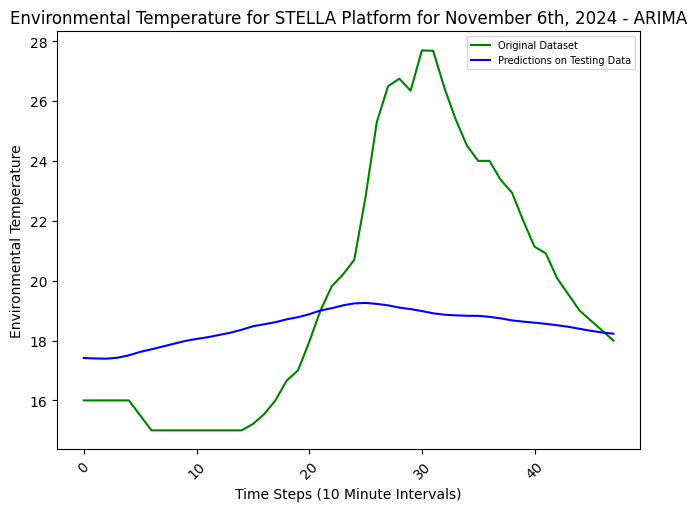

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['Tamb'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(predictions_arima_tamb, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for November 6th, 2024 - ARIMA')
plt.show()

After ambient temperature, model for solar irradiance is trained and irradiance is predicted.

In [ ]:
# Training data
train_df = df_Compiegne_g[(df_Compiegne_g.index < '2023-09-06') & (df_Compiegne_g.index >= '2023-03-22')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_g[(df_resampled_g.index < '2024-09-07') & (df_resampled_g.index >= '2024-09-06')]
test_df = test_df.to_frame()

In [ ]:
print(np.shape(train_df))
print(np.shape(test_df))

(3216, 1)
(48, 1)


In [ ]:
# Preparing dataset for ARIMA training

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train = reframe_datasets(df_lstm_training, n_input)
test = df_lstm_testing

In [ ]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = n_output
n_steps = n_input
percentage = 0

model_arima = ARIMA(history_arima, order=(n_steps,0,0))
model_fit = model_arima.fit()

# walk-forward validation
while check:

	# Forecast n_forecast steps ahead
	output_arima = model_fit.forecast(steps=n_forecast)
	yhat_arima = output_arima[:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for next n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_fit = model_fit.append(actual_values, refit=False)

	# Compute RMSE for these 7 predictions
	multiple_rmse = np.sqrt(np.mean((yhat_arima - actual_values) ** 2))
	rmse_per_prediction.append(multiple_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted 48 steps ahead | RMSE=0.292680 | 100% complete


In [ ]:
# evaluate predictions hours for each day
predictions_arima = array(predictions_arima)

# Reshape `predictions` before inverse transform
n_samples = predictions_arima.shape
predictions_arima_g = predictions_arima.reshape(n_samples[0] * 1, 1)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler.min_[0].reshape(1,)
target_scaler.scale_ = scaler.scale_[0].reshape(1,)
target_scaler.data_min_ = scaler.data_min_[0].reshape(1,)
target_scaler.data_max_ = scaler.data_max_[0].reshape(1,)
target_scaler.data_range_ = scaler.data_range_[0].reshape(1,)

predictions_arima_g = target_scaler.inverse_transform(predictions_arima_g)

test_reshaped = scaler.inverse_transform(test_arima)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_reshaped, predictions_arima_g))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 183.008


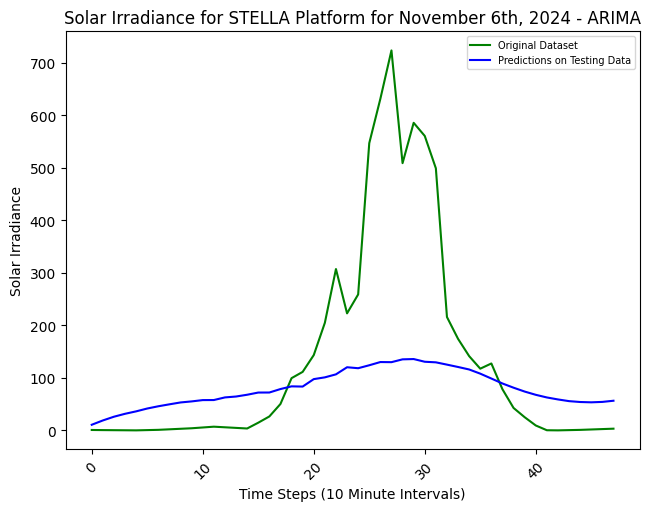

In [ ]:
# Plot baseline and predictions

plt.plot(test_df['g'].values, 'g', label='Original Dataset') # Change the column name for different predictions
plt.plot(predictions_arima_g, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Irradiance')
plt.title('Solar Irradiance for STELLA Platform for November 6th, 2024 - ARIMA')
plt.show()

In [ ]:
# Output the results into a text file
start_time = datetime.strptime("00:00:00", "%H:%M:%S")
time_interval = timedelta(minutes=60) # Should be the same as the resampling interval

with open("06092024-ARIMA.txt", "w") as f: # Change the name of the text file depending on the day
    for i in range(n_output):
        current_time = (start_time + i * time_interval).strftime("%H:%M:%S")
        line = f"{current_time},{predictions_arima_tamb[i][0]},{predictions_arima_g[i][0]}\n"
        f.write(line)